<a href="https://colab.research.google.com/github/AvichalTrivedi7/Generative-AI-Intel-Unnati/blob/main/CIFAR_10_CNN_Operations_%2B_OpenVINO_Conversion_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
!pip install openvino
import openvino as ov

In [29]:
# Setting parameters
IMAGE_SIZE = 32
CHANNELS = 3

In [30]:
# Defining kernel (Convolution layer)
conv = nn.Conv2d(
    in_channels=3,
    out_channels=1,   # single filter for simplicity
    kernel_size=3,
    padding=1
)

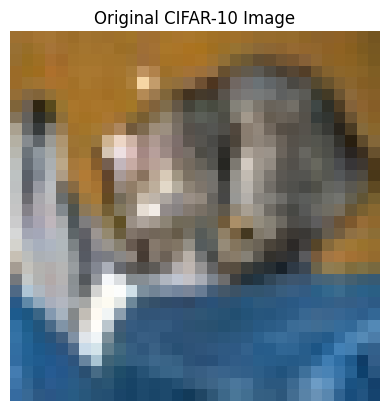

In [31]:
# Loading one CIFAR-10 image and plot it
transform = transforms.ToTensor()

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

image, label = dataset[0]

# Plot original image
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title("Original CIFAR-10 Image")
plt.axis('off')
plt.show()

In [32]:
# Reformatting the image (Add batch dimension)

image = image.unsqueeze(0)   # Shape: (1, 3, 32, 32)
print("Image shape:", image.shape)

Image shape: torch.Size([1, 3, 32, 32])


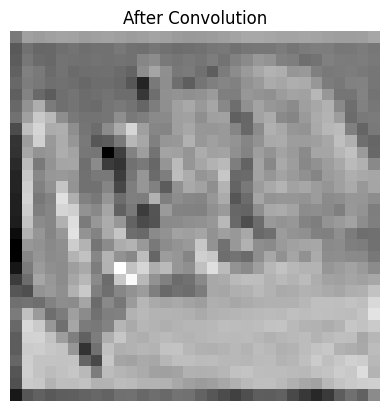

In [33]:
# Applying Convolution layer and plot output

conv_output = conv(image)

plt.imshow(conv_output[0, 0].detach().numpy(), cmap='gray')
plt.title("After Convolution")
plt.axis('off')
plt.show()

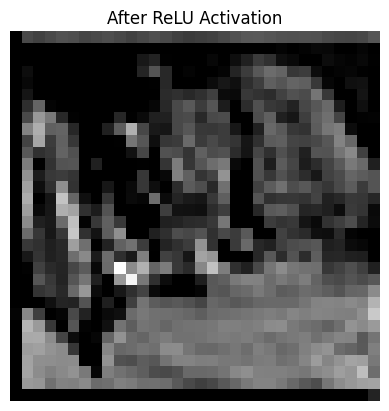

In [34]:
# Applying Activation layer (ReLU) and plot

relu = nn.ReLU()
relu_output = relu(conv_output)

plt.imshow(relu_output[0, 0].detach().numpy(), cmap='gray')
plt.title("After ReLU Activation")
plt.axis('off')
plt.show()

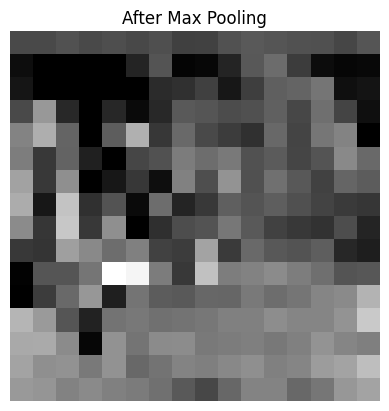

In [35]:
# Applying Pooling layer and plot

pool = nn.MaxPool2d(2, 2)
pool_output = pool(relu_output)

plt.imshow(pool_output[0, 0].detach().numpy(), cmap='gray')
plt.title("After Max Pooling")
plt.axis('off')
plt.show()

In [36]:
# Creating a minimal CNN model

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 8, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        return x

model = SimpleCNN()
model.eval()

SimpleCNN(
  (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [37]:
# Converting PyTorch model to OpenVINO IR
!pip install onnxscript

dummy_input = torch.randn(1, 3, 32, 32)
torch.onnx.export(
    model,
    dummy_input,
    "simple_cnn.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

W1216 03:41:04.410000 362 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `SimpleCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SimpleCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cpu',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,3,32,32]>
            ),
            outputs=(
                %"output"<FLOAT,[1,8,16,16]>
            ),
            initializers=(
                %"conv.weight"<FLOAT,[8,3,3,3]>{TorchTensor(...)},
                %"conv.bias"<FLOAT,[8]>{TorchTensor<FLOAT,[8]>(Parameter containing: tensor([ 0.0693, -0.0832,  0.0277, -0.1014, -0.0603,  0.1405, -0.0390,  0.0959], requires_grad=True), name='conv.bias')}
            ),
        ) {
            0 |  # node_conv2d
                 %"conv2d"<FLOAT,[1,8,32,32]> ⬅️ ::Conv(%"input", %"conv.weight"{...}, %"conv.bias"{[0.06927694380283356, -0.08324645459651947, 0.02771596610546112, -0.10143261402845383, -0.060

In [38]:
# Convert ONNX → OpenVINO IR

ov_model = ov.convert_model("simple_cnn.onnx")
ov.save_model(ov_model, "simple_cnn.xml")


W1216 03:41:07.858000 362 torch/export/pt2_archive/_package.py:943] Unable to load package. f must be a buffer or a file ending in .pt2. Instead got {/content/simple_cnn.onnx}
W1216 03:41:07.864000 362 torch/export/__init__.py:451] Ran into the following error when deserializing: PytorchStreamReader failed reading zip archive: failed finding central directory


In [39]:
!ls

data	     simple_cnn.bin   simple_cnn.onnx.data
sample_data  simple_cnn.onnx  simple_cnn.xml
